In [1]:
import pandas as pd
from gurobi import *
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)

In [3]:
booking = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Booking_new.xlsx")
bd_zones = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/BreakDownZones.xlsx")
dz_to_bd = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/DistanceMatrixDropZoneToBreakDownZone.xlsx")
drop_zones = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/DropZones.xlsx")
bu_zones = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='BU Zones')
bu_zones_workstations = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='WorkStation')
bu_zones_to_flight = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='FlightNumber-BUZone')
flight_default_processing = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='DefaultProcessingTime')
flight_pre_processing = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='Pre-ProcessingBufferTime')

In [4]:
dz = list(drop_zones['Name'].unique())
break_down_zones = list(bd_zones['Name'].unique())

In [5]:
dz_to_bd[['h','m','s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in dz_to_bd['TransportDuration']])
bd_zones[['handling_h','handling_m','handling_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in bd_zones['HandlingTimePerULD']])
bd_zones[['transport_WH_h','transport_WH_m','transport_WH_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in bd_zones['TransportationTimeToWH']])

In [6]:
booking['key_shipment_id_arrival_date'] = booking['Shipment ID'].astype(str) + booking['ShipmentArrivalDateUTC'].astype(str)
booking = booking.drop_duplicates('key_shipment_id_arrival_date')

In [7]:
booking = booking[booking.TotalWeight<=400]

In [8]:
#####################################################################################
#Handling multiple ULDs having same number arriving less than 4 hours

In [9]:
uld_number_times = booking[['ShipmentArrivalDateUTC', 'ArrivalULDNumber']]
uld_number_times['id'] = booking['ShipmentArrivalDateUTC'].astype(str) + '_' + booking['ArrivalULDNumber'].astype(str)
uld_number_times = uld_number_times.drop_duplicates('id')
uld_number_times.shape

/home/luckshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(312, 3)

In [10]:
uld_number_times['count_uld_number'] = 1

In [11]:
unique_uld_count_by_number = uld_number_times.groupby(['ArrivalULDNumber']).agg({"count_uld_number":"count"}).rename(columns={"count_uld_number":"Count"}).reset_index()
multiple_uld_numbers = unique_uld_count_by_number[unique_uld_count_by_number.Count>1]

In [12]:
multiple_uld_number_and_times = uld_number_times[uld_number_times['ArrivalULDNumber'].isin((multiple_uld_numbers['ArrivalULDNumber'].unique()))]
multiple_uld_number_and_times = multiple_uld_number_and_times.sort_values(by=['ArrivalULDNumber', 'ShipmentArrivalDateUTC'])
multiple_uld_number_and_times['arrival_time'] = pd.to_datetime(multiple_uld_number_and_times['ShipmentArrivalDateUTC'])
multiple_uld_number_and_times['diff'] = multiple_uld_number_and_times.sort_values(by=['ArrivalULDNumber', 'arrival_time']).groupby('ArrivalULDNumber')['arrival_time'].diff()
multiple_ULD_arriving_below_4_hours = list(multiple_uld_number_and_times[multiple_uld_number_and_times['diff'].notnull() & (multiple_uld_number_and_times['diff'] < pd.Timedelta(4, unit='h'))]['ArrivalULDNumber'].unique())
booking = booking[~booking['ArrivalULDNumber'].isin(multiple_ULD_arriving_below_4_hours)]

In [13]:
#######################################################################################

In [14]:
# Filtering shipments arriving after departure
booking['Shipment_arrival_date_time'] = pd.to_datetime(booking['ShipmentArrivalDateUTC'])
booking = booking[booking.ShipmentDepartureDateUTC != '2018-10-24T26:20:00']
booking['Shipment_departure_date_time'] = pd.to_datetime(booking['ShipmentDepartureDateUTC'])
booking['Shipment_duration'] = booking['Shipment_departure_date_time']-booking['Shipment_arrival_date_time']
booking = booking[booking.Shipment_duration>pd.Timedelta(0)]

In [15]:
#######################################################################################

In [16]:
booking['count_shipments'] = 1
multple_dropzone_check = booking.pivot_table(index=['ArrivalULDNumber', 'Shipment_arrival_date_time'], columns='DropZone', values= 'count_shipments').reset_index()
multple_dropzone_check = multple_dropzone_check.fillna(0)
multple_dropzone_check['Two_different_dropzones_check'] = multple_dropzone_check['DZ NML-1'] + multple_dropzone_check['DZ NRML-1'] + multple_dropzone_check['DZ NRML-2']
unique_dropzone_check = multple_dropzone_check[multple_dropzone_check.Two_different_dropzones_check==1.0]
two_drop_zones = multple_dropzone_check[multple_dropzone_check.Two_different_dropzones_check>1.0]

In [17]:
two_drop_zones['unique_id'] = two_drop_zones['ArrivalULDNumber'].astype(str) + '_' + (pd.to_timedelta(two_drop_zones['Shipment_arrival_date_time']).astype('timedelta64[m]').astype(int).astype(str))

/home/luckshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  """Entry point for launching an IPython kernel.
/home/luckshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
dz_to_bd['DropZoneName_filter'] = dz_to_bd['DropZoneName'].apply(lambda x: x.split('-')[0]).str[3:]
dz_to_bd['bd_type1'] = dz_to_bd['BreakDownZoneName'].apply(lambda x: x.split(' ')[1])
dz_to_bd.loc[dz_to_bd['BreakDownZoneName'] == 'B BD NRML-1', 'bd_type1'] = "NRML-1"
dz_to_bd.loc[dz_to_bd['BreakDownZoneName'] == 'B BD NRML-2', 'bd_type1'] = "NRML-2"
dz_to_bd['bd_type'] =  dz_to_bd['bd_type1'].apply(lambda x: x.split('-')[0])
dz_to_bd['check'] = np.where(dz_to_bd['DropZoneName_filter']==dz_to_bd['bd_type'], 1, 0)
dz_to_bd = dz_to_bd[dz_to_bd['check']==1]
dz_to_bd = dz_to_bd[['BreakDownZoneName', 'DropZoneName', 'TransportDuration', 'h', 'm', 's']]

In [19]:
dz_ship_data = booking[['DropZone','ArrivalULDNumber', 'ShipmentArrivalDateUTC']]
dz_ship_data['unique_key'] =  dz_ship_data['DropZone'].astype(str) + '_' + dz_ship_data['ArrivalULDNumber'].astype(str) + '_' + dz_ship_data['ShipmentArrivalDateUTC'].astype(str)
dz_ship_data = dz_ship_data.drop_duplicates('unique_key')
dz_ship_data = dz_ship_data[['DropZone', 'ArrivalULDNumber', 'ShipmentArrivalDateUTC']]

/home/luckshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
uld_bd_data = pd.merge(dz_ship_data, dz_to_bd, left_on='DropZone', right_on='DropZoneName')

In [21]:
uld_bd_data['key'] = uld_bd_data['DropZone'].astype(str) + '_' + uld_bd_data['ArrivalULDNumber'].astype(str) + '_' + uld_bd_data['ShipmentArrivalDateUTC'].astype(str) + '_' + uld_bd_data['BreakDownZoneName'].astype(str)
uld_bd_data = uld_bd_data.drop_duplicates('key')

In [22]:
uld_bd_data['Shipment_arrival_date_time'] = pd.to_datetime(uld_bd_data['ShipmentArrivalDateUTC'])

In [23]:
#Getting BU workstations count
bu_workstation_count = bu_zones_workstations.groupby(['Name']).count().reset_index()
bu_workstation_count.columns = ['Name', 'Count']

In [25]:
bu_zones_data = pd.merge(bu_zones_to_flight, bu_zones, left_on='BU Zone', right_on='Name')
bu_zone_all = pd.merge(bu_zones_data, bu_workstation_count, left_on='BU Zone', right_on='Name')

In [26]:
bu_zone_all[['handling_ULD_h','handling_ULD_m','handling_ULD_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in bu_zone_all['HandlingTimePerULD']])
bu_zone_all[['transport_WH_h','transport_WH_m','transport_WH_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in bu_zone_all['TransportationTimeToWH']])

In [27]:
#Creating booking_new variable for future use
booking['build_up_arrival_time'] =  booking['Shipment_arrival_date_time'] #+ np.timedelta64(2, 'h')
booking['build_up_finish_time'] =  booking['Shipment_departure_date_time'] #- np.timedelta64(1, 'h')
booking_new = booking[['ProductName', 'Priority', 'DropZone', 'ArrivalULDNumber', 'Pieces', 'Weight', 'TotalWeight',
         'FlightNumberDeparture', 'Shipment_arrival_date_time', 'Shipment_departure_date_time',
         'Shipment_duration', 'build_up_arrival_time', 'build_up_finish_time']]

In [28]:
booking_new = pd.merge(booking_new, bu_zone_all, left_on='FlightNumberDeparture', right_on='FlightNumber')

In [29]:
booking_new[['ULD_handling_h','ULD_handling_m','ULD_handling_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in booking_new['HandlingTimePerULD']])
booking_new['arrival_date'] = booking_new['Shipment_arrival_date_time'].dt.normalize()
booking_new['departure_date'] = booking_new['Shipment_departure_date_time'].dt.normalize()

In [30]:
# DataFrame used in  BD zone
#sample_shipments = booking_new.iloc[98:118,:]
# sample_shipments = booking_new[booking_new['ArrivalULDNumber'].isin(list([34842, 34222, 92870, 21231, 49815, 51228, 59243]))]
# sample_shipments = booking_new[booking_new['ArrivalULDNumber'].isin(list([34842, 34222, 92870]))]
# sample_shipments = booking_new[booking_new['ArrivalULDNumber'].isin(list([34842, 34222,92870, 21231, 49815, 59243]))]
# sample_shipments = booking_new[booking_new['ArrivalULDNumber'].isin(list([51228]))]
sample_shipments = booking_new

In [31]:
sample_shipments['Shipment_duration_minutes'] = (sample_shipments['Shipment_duration'] / np.timedelta64(1, 'm')).astype(int)
sample_shipments['Shipment_arrival_time_minutes'] = pd.to_timedelta(sample_shipments['Shipment_arrival_date_time']).astype('timedelta64[m]').astype(int)
sample_shipments['Shipment_departure_time_minutes'] = pd.to_timedelta(sample_shipments['Shipment_departure_date_time']).astype('timedelta64[m]').astype(int)

/home/luckshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  
/home/luckshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
new = sample_shipments[['DropZone','ArrivalULDNumber', 'Shipment_arrival_date_time', 'Shipment_duration_minutes','Shipment_arrival_time_minutes', 'Shipment_departure_time_minutes']]
df_merge= pd.merge(uld_bd_data, new, on=['DropZone','ArrivalULDNumber', 'Shipment_arrival_date_time'])
df_merge = df_merge.drop_duplicates('key')
bd_capacity = bd_zones[['Name','NumberOfWorkstations', 'handling_m']]
df_merge1 = df_merge.merge(bd_capacity, left_on='BreakDownZoneName', right_on='Name')

In [33]:
#BD process needed to to be completed with in 60 minutes
df_merge1['one_hour_duration'] = 60

In [34]:
df_merge1['unique_id'] = df_merge1['ArrivalULDNumber'].astype(str) + '_' + df_merge1['Shipment_arrival_time_minutes'].astype(str)

In [35]:
#two_drop_zones_ULD_Numbers = list(two_drop_zones['unique_id'].unique())
two_drop_zones_ULD_Numbers = list(two_drop_zones[two_drop_zones['ArrivalULDNumber'].isin([34842, 34222, 92870, 21231, 49815, 51228, 59243])]['unique_id'].unique())

In [36]:
uld_uniqueid_list = list(df_merge1['unique_id'].unique())

In [37]:
ArrivalULDNumber_list = list(df_merge1['ArrivalULDNumber'].unique())
BreakDownZoneName_list = list(df_merge1['BreakDownZoneName'].unique())

In [38]:
#############################################################################################################
##################################################################################################################
###############################################################################################################################################

In [39]:
booking_new_BU = sample_shipments

In [40]:
booking_new_BU['shipment_ID'] = range(1, len(booking_new_BU) + 1)
shipment_id_list = list(booking_new_BU['shipment_ID'].unique())

In [41]:
#Data used for BU process 'sample_shipments_bu'
sample_shipments_bu = booking_new_BU

In [42]:
sample_shipments_bu['unique_id'] = sample_shipments_bu['ArrivalULDNumber'].astype(str) + '_' + sample_shipments_bu['Shipment_arrival_time_minutes'].astype(str)

In [43]:
ArrivalULDNumber_list = list(sample_shipments_bu['ArrivalULDNumber'].unique())
filghts_list = list(sample_shipments_bu['FlightNumberDeparture'].unique())
bu_zones_list = list(sample_shipments_bu['Name_x'].unique())

In [44]:
##################################################################################
#####################################################################################
#######################################################################################

In [45]:
# Full Model

In [46]:
model = Model('Full model')

Academic license - for non-commercial use only


In [47]:
#Discretisation has been done based on each BD zone handling times
x = {}
for i in uld_uniqueid_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.unique_id==i]['BreakDownZoneName'])
    #print(BreakDownZoneName_list1)
    for j in BreakDownZoneName_list1:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.unique_id==i) & (df_merge1.BreakDownZoneName==j)]
        min_time = min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique()))
        arr = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
            #print(arr,"--",i)
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        handling_minutes = list(new_check['handling_m'].unique())[0]
            #print(shipment_arrival_time_minutes_loop, handling_minutes)
        t_start = (min_time + (math.ceil((arr-min_time)/handling_minutes)*handling_minutes))
            #print(arr,"-----",t_start)
        #if(i == '51228_25671360'):   
            #print(t_start)
        for k in range(t_start, t_start+shipment_arrival_duation_minutes_loop, handling_minutes):
            x[i,j,k] = model.addVar(vtype=GRB.BINARY)

In [48]:
z = {}
for i in ArrivalULDNumber_list:
    shipment_date_list = list(sample_shipments_bu[sample_shipments_bu.ArrivalULDNumber==i]['departure_date'].unique())
    for d in shipment_date_list:
        shipment_list = list(sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.departure_date==d)]['shipment_ID'])
        #print(shipment_list)
        for l in shipment_list:
        #print(int(i),str(j))
            number_of_ws = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Count'].unique()[0]
            shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_departure_time_minutes'].unique()[0]
            for m in range(1,number_of_ws+1):
                for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop):
                    z[l,m,t] = model.addVar(vtype=GRB.BINARY)

In [49]:
q = {}
for k in filghts_list:
    shipment_date_list = list(sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['departure_date'].unique())
    for d in shipment_date_list:
        ws_list = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['Count'].unique()[0]
        shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['Shipment_departure_time_minutes'].unique()[0]
    #print(shipment_list)
        for m in range(1, ws_list+1):
        #print(int(i),str(j))
            for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop):
                q[k,m,t] = model.addVar(vtype=GRB.BINARY)

In [50]:
#BD Constraints

In [51]:
# #Handling time of each bd zone take into account for the quicksum
for i in (list(set(uld_uniqueid_list) - set(two_drop_zones_ULD_Numbers))):
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.unique_id==i]['BreakDownZoneName'])
    new_check = df_merge1[(df_merge1.unique_id==i)]
    arr = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    #min_time = min(list(df_merge1[df_merge1.BreakDownZoneName.isin(BreakDownZoneName_list1)]['Shipment_arrival_time_minutes'].unique()))
    #t_start = shipment_arrival_time_minutes_loop + (handling_minutes - (shipment_arrival_time_minutes_loop%min_time))
    model.addConstr(quicksum(x[i,b,c] for b in BreakDownZoneName_list1 for c in range((min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])) == 1)

In [52]:
# #Handling time of each bd zone take into account for the quicksum
for i in two_drop_zones_ULD_Numbers:
    #print(i)
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.unique_id==i]['BreakDownZoneName'])
    bd_NML_list = [k for k in BreakDownZoneName_list1 if 'NML' in k]
    bd_NRML_list = [k for k in BreakDownZoneName_list1 if 'NRML' in k]
    #print(BreakDownZoneName_list1)
    #print(bd_NML_list)
    #print(bd_NRML_list)
    new_check = df_merge1[(df_merge1.unique_id==i)]
    arr = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    #print(arr)
    shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    #min_time = min(list(df_merge1[df_merge1.BreakDownZoneName.isin(BreakDownZoneName_list1)]['Shipment_arrival_time_minutes'].unique()))
    #t_start = shipment_arrival_time_minutes_loop + (handling_minutes - (shipment_arrival_time_minutes_loop%min_time))
    model.addConstr(quicksum(x[i,b,c] for b in bd_NML_list for c in range((min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])) == 1)
    model.addConstr(quicksum(x[i,b,c] for b in bd_NRML_list for c in range((min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])) == 1)

In [53]:
#Precedence of NML before NRML
for i in two_drop_zones_ULD_Numbers:
    #print(i)
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.unique_id==i]['BreakDownZoneName'])
    bd_NML_list = [k for k in BreakDownZoneName_list1 if 'NML' in k]
    bd_NRML_list = [k for k in BreakDownZoneName_list1 if 'NRML' in k]
    #print(BreakDownZoneName_list1)
    #print(bd_NML_list)
    #print(bd_NRML_list)
    new_check = df_merge1[(df_merge1.unique_id==i)]
    arr = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    #print(arr)
    shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    #min_time = min(list(df_merge1[df_merge1.BreakDownZoneName.isin(BreakDownZoneName_list1)]['Shipment_arrival_time_minutes'].unique()))
    #t_start = shipment_arrival_time_minutes_loop + (handling_minutes - (shipment_arrival_time_minutes_loop%min_time))
    model.addConstr(quicksum((c+(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*x[i,b,c] for b in bd_NML_list for c in range((min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])) <= quicksum(c*x[i,b,c] for b in bd_NRML_list for c in range((min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])))

In [54]:
#BD Assgnment Time constraint
for i in (list(set(uld_uniqueid_list) - set(two_drop_zones_ULD_Numbers))):
    #for j in BreakDownZoneName_list:
        #print(int(i),str(j))
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.unique_id==i]['BreakDownZoneName'])
    new_check = df_merge1[(df_merge1.unique_id==i)]
    arr = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    #arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    transport_time_each_bd_zone = list(new_check['m'].unique())[0]
    model.addConstr(quicksum((c-df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['m'])*x[i,b,c] for b in BreakDownZoneName_list1 for c in range((min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])) >= arr)
        #for k in range(shipment_arrival_duation_minutes_loop):

In [55]:
#BD Assgnment Time constraint
for i in two_drop_zones_ULD_Numbers:
    #for j in BreakDownZoneName_list:
        #print(int(i),str(j))
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.unique_id==i]['BreakDownZoneName'])
    bd_NML_list = [k for k in BreakDownZoneName_list1 if 'NML' in k]
    new_check = df_merge1[(df_merge1.unique_id==i)]
    arr = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    #arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    transport_time_each_bd_zone = list(new_check['m'].unique())[0]
    model.addConstr(quicksum((c-df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['m'])*x[i,b,c] for b in bd_NML_list for c in range((min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((arr-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])) >= arr)
        #for k in range(shipment_arrival_duation_minutes_loop):

In [56]:
for j in BreakDownZoneName_list:
        #print(int(i),str(j))
    new_check = df_merge1[df_merge1.BreakDownZoneName==j]
    min_time = min(list(new_check['Shipment_arrival_time_minutes'].unique()))
    max_time = max(list(new_check['Shipment_departure_time_minutes'].unique()))
    uld_break = list(new_check['unique_id'].unique())
    #shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    #shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    handling_minutes = list(new_check['handling_m'].unique())[0]
    #print(handling_minutes)
    cap = list(new_check['NumberOfWorkstations'].unique())[0]
    for t in range(min_time, max_time-handling_minutes-1, handling_minutes):
        #print(t)
        uld_list1=[]
        for i in uld_break:
            if(t in range((min_time + (math.ceil((new_check[new_check.unique_id==i].iloc[0]['Shipment_arrival_time_minutes']-min_time)/df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'])*df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'])), (min_time + (math.ceil((new_check[new_check.unique_id==i].iloc[0]['Shipment_arrival_time_minutes']-min_time)/df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'])*df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))+shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'])):#new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_departure_time_minutes'])): 
                uld_list1.append(i)
                #print(t,uld_list1)
        if(len(uld_list1)!=0):
            model.addConstr(quicksum(x[a,j,t] for a in uld_list1) <= cap)

In [57]:
##########################################################################################################################################################################################
##########################################################################################################################################################################################

In [58]:
#BU Constraints

In [59]:
for k in filghts_list:
    shipment_date_list = list(sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['departure_date'].unique())
    for d in shipment_date_list:
        shipment_list = list(sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['shipment_ID'])
        ws_list = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['Count'].unique()[0]
        shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['Shipment_departure_time_minutes'].unique()[0]
    #print(shipment_list)
        for l in shipment_list:
        #print(int(i),str(j))
            model.addConstr(quicksum(z[l,m,t] for m in range(1, ws_list+1) for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop))==1)

In [60]:
for k in filghts_list:
    shipment_date_list = list(sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['departure_date'].unique())
    for d in shipment_date_list:
        shipment_list = list(sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['shipment_ID'])
        ws_list = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['Count'].unique()[0]
        shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['Shipment_departure_time_minutes'].unique()[0]
        bu_handling_time = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['handling_ULD_m'].unique()[0]
        #print(bu_handling_time.dtype)
    #print(shipment_list)
        for m in range(1, ws_list+1):
            for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop-bu_handling_time):
                model.addConstr(400*q[k,m,t] - quicksum(sample_shipments_bu[sample_shipments_bu.shipment_ID==l].iloc[0]['TotalWeight']*z[l,m,t] for l in shipment_list) 
                                >= quicksum(sample_shipments_bu[sample_shipments_bu.shipment_ID==l].iloc[0]['TotalWeight']*z[l,m,tau] for l in shipment_list for tau in range(t+1,t+bu_handling_time)))    

In [61]:
for k in filghts_list:
    shipment_date_list = list(sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['departure_date'].unique())
    for d in shipment_date_list:
        shipment_list = list(sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k)  & (sample_shipments_bu.departure_date==d)]['shipment_ID'])
        ws_list = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k)   & (sample_shipments_bu.departure_date==d)]['Count'].unique()[0]
        shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k)  & (sample_shipments_bu.departure_date==d)]['Shipment_departure_time_minutes'].unique()[0]
        bu_handling_time = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k)  & (sample_shipments_bu.departure_date==d)]['handling_ULD_m'].unique()[0]
        model.addConstr(quicksum(q[k,m,t] for m in range(1, ws_list+1) for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop)) <= (quicksum(sample_shipments_bu[sample_shipments_bu.shipment_ID==l].iloc[0]['TotalWeight']*z[l,m,t] for l in shipment_list for t in range(shipment_departure_time_minutes_loop-60,shipment_departure_time_minutes_loop) for m in range(1, ws_list+1))/400) + 1)

In [62]:
for k in filghts_list:
    shipment_date_list = list(sample_shipments_bu[sample_shipments_bu.FlightNumberDeparture==k]['departure_date'].unique())
    for d in shipment_date_list:
        bu_zone_for_flight = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['Name_x'].unique()[0]
        othe_flights_df = sample_shipments_bu[(sample_shipments_bu.Name_x==bu_zone_for_flight) & (sample_shipments_bu.departure_date==d)]
        ws_list = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['Count'].unique()[0]
        shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['Shipment_departure_time_minutes'].unique()[0]
        other_flights = list(othe_flights_df[(othe_flights_df['FlightNumberDeparture'].isin([k]) == False) & (othe_flights_df.departure_date==d)]['FlightNumberDeparture'].unique())
        bu_handling_time = sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==k) & (sample_shipments_bu.departure_date==d)]['handling_ULD_m'].unique()[0]
        #print(k, "----",filghts_list,"-------", other_flights) 
        #print(shipment_list)
        for m in range(1, ws_list+1):
        #print(int(i),str(j))
            for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop - bu_handling_time):
                other_list  =[]
                for i in other_flights:
                    if(t in range((sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==i)].iloc[0]['Shipment_departure_time_minutes']-60),sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==i)].iloc[0]['Shipment_departure_time_minutes'])): 
                        other_list.append(i)
                #print(k, "----",other_list)
                if(len(other_list)!=0):
                    model.addConstr(1-q[k,m,t] >= quicksum(q[p,m,ta] for p in other_list for ta in range(t,min(t+bu_handling_time,(sample_shipments_bu[(sample_shipments_bu.FlightNumberDeparture==p)].iloc[0]['Shipment_departure_time_minutes'])))))

In [63]:
for i in (list(set(uld_uniqueid_list) - set(two_drop_zones_ULD_Numbers))):
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.unique_id==i]['BreakDownZoneName'])
    shipment_date_list = list(sample_shipments_bu[sample_shipments_bu.unique_id==i]['departure_date'].unique())
    for d in shipment_date_list:
        shipment_list = list(sample_shipments_bu[(sample_shipments_bu.unique_id==i) & (sample_shipments_bu.departure_date==d)]['shipment_ID'])
        #print(shipment_list)
        for l in shipment_list:
            number_of_ws = sample_shipments_bu[(sample_shipments_bu.unique_id==i) & (sample_shipments_bu.shipment_ID==l)]['Count'].unique()[0]
            shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.unique_id==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_departure_time_minutes'].unique()[0]
            #shipment_arrival_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.unique_id==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_arrival_time_minutes'].unique()[0]
            new_check = df_merge1[(df_merge1.unique_id==i)]
            shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
            model.addConstr(quicksum(t*z[l,m,t] for m in range(1, ws_list+1) for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop)) >=
                            quicksum((k + df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'] + 
                                      df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['m'])*x[i,b,k] for b in BreakDownZoneName_list1 for k in range((min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])), name="Constraint 9")

In [64]:
for i in (two_drop_zones_ULD_Numbers):
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.unique_id==i]['BreakDownZoneName'])
    bd_NRML_list = [k for k in BreakDownZoneName_list1 if 'NRML' in k]
    shipment_date_list = list(sample_shipments_bu[sample_shipments_bu.unique_id==i]['departure_date'].unique())
    for d in shipment_date_list:
        shipment_list = list(sample_shipments_bu[(sample_shipments_bu.unique_id==i) & (sample_shipments_bu.departure_date==d)]['shipment_ID'])
        #print(shipment_list)
        for l in shipment_list:
            number_of_ws = sample_shipments_bu[(sample_shipments_bu.unique_id==i) & (sample_shipments_bu.shipment_ID==l)]['Count'].unique()[0]
            shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.unique_id==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_departure_time_minutes'].unique()[0]
            #shipment_arrival_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.unique_id==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_arrival_time_minutes'].unique()[0]
            new_check = df_merge1[(df_merge1.unique_id==i)]
            shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
            model.addConstr(quicksum(t*z[l,m,t] for m in range(1, ws_list+1) for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop)) >=
                            quicksum((k + df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'] + 
                                      df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['m'])*x[i,b,k] for b in bd_NRML_list for k in range((min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])), name="Constraint Others")

In [65]:
obj = 0
for i in ArrivalULDNumber_list:
    shipment_date_list = list(sample_shipments_bu[sample_shipments_bu.ArrivalULDNumber==i]['departure_date'].unique())
    for d in shipment_date_list:
        shipment_list = list(sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.departure_date==d)]['shipment_ID'])
    #print(shipment_list)
        for l in shipment_list:
        #print(int(i),str(j))
            number_of_ws = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Count'].unique()[0]
            shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_departure_time_minutes'].unique()[0]
            obj += quicksum(t*z[l,m,t] for m in range(1,number_of_ws+1) for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop))

In [66]:
model.setObjective(obj, GRB.MINIMIZE)
model.optimize()

Optimize a model with 22165 rows, 205838 columns and 2934086 nonzeros
Variable types: 0 continuous, 205838 integer (205838 binary)
Coefficient statistics:
  Matrix range     [5e-04, 3e+07]
  Objective range  [3e+07, 3e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+07]
Presolve removed 4228 rows and 45306 columns (presolve time = 5s) ...
Presolve removed 4942 rows and 77243 columns (presolve time = 11s) ...
Presolve removed 4990 rows and 78517 columns (presolve time = 17s) ...
Presolve removed 21658 rows and 202650 columns
Presolve time: 19.76s
Presolved: 507 rows, 3188 columns, 10367 nonzeros
Variable types: 0 continuous, 3188 integer (3188 binary)
Found heuristic solution: objective 1.715094e+10

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1784918e+10   3.804300e+04   0.000000e+00     21s
     506    1.7150927e+10   0.000000e+00   0.000000e+00     21s

Root relaxation: objective 1.715093e+10, 506 iterations, 

In [67]:
import datetime
print(datetime.datetime.now())

2019-06-30 01:50:25.404908


In [488]:
model.computeIIS()
model.write('Infesible_Model.ilp')


Computing Irreducible Inconsistent Subsystem (IIS)...

      Constraints           Bounds       Runtime
     Min       Max       Min      Max
------------------------------------------------
        0     3844         0        0         0s
        3        3         0        0         2s

IIS computed: 3 constraints, 0 bounds
IIS runtime: 1.58 seconds


In [ ]:
if(model.status== GRB.INFEASIBLE):
    model.computeIIS()
    

In [68]:
model.write('Full Model.lp')

In [69]:
for i in uld_uniqueid_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.unique_id==i]['BreakDownZoneName'])
    #print(i, "in", BreakDownZoneName_list1)
    for j in BreakDownZoneName_list1:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.unique_id==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range((min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']):
            if x[i,j,k].x > 0.5:
                print("ULD", i, "assigned to BD", j, "at", k)
                #print(k)
            #if(i == '51228_25671360'):
                #print(x)
                    

ULD 21231_25671250 assigned to BD BD NRML-4 at 25671312
ULD 21231_25671250 assigned to BD BD NML-3 at 25671280
ULD 24321_25671250 assigned to BD BD NRML-1 at 25671270
ULD 42309_25671550 assigned to BD BD NRML-1 at 25671570
ULD 49809_25673105 assigned to BD BD NRML-4 at 25673119
ULD 44509_25671785 assigned to BD BD NRML-1 at 25671790
ULD 44509_25673225 assigned to BD BD NRML-1 at 25673230
ULD 34521_25671730 assigned to BD BD NRML-1 at 25671750
ULD 34576_25671730 assigned to BD BD NRML-1 at 25671750
ULD 34849_25673345 assigned to BD BD NRML-1 at 25673350
ULD 53252_25671910 assigned to BD BD NRML-4 at 25671923
ULD 92841_25672010 assigned to BD BD NRML-4 at 25672027
ULD 92852_25680385 assigned to BD BD NRML-1 at 25680390
ULD 92852_25671325 assigned to BD BD NRML-1 at 25671330
ULD 92854_25674170 assigned to BD BD NRML-4 at 25674185
ULD 92854_25672730 assigned to BD B BD NRML-1 at 25672750
ULD 92862_25671510 assigned to BD BD NRML-1 at 25671530
ULD 92863_25672040 assigned to BD BD NRML-1 at 

ULD 51209_25674495 assigned to BD BD NRML-1 at 25674510
ULD 51210_25671890 assigned to BD BD NRML-1 at 25671910
ULD 51212_25671720 assigned to BD BD NRML-1 at 25671730
ULD 51213_25672000 assigned to BD BD NRML-1 at 25672010
ULD 51214_25673155 assigned to BD BD NRML-1 at 25673170
ULD 51215_25674260 assigned to BD BD NRML-1 at 25674270
ULD 51221_25673350 assigned to BD BD NRML-4 at 25673366
ULD 51223_25672075 assigned to BD BD NRML-1 at 25672090
ULD 51233_25674320 assigned to BD BD NRML-1 at 25674330
ULD 51235_25671570 assigned to BD BD NRML-4 at 25671585
ULD 59239_25671760 assigned to BD BD NRML-1 at 25671770
ULD 59243_25671650 assigned to BD B BD NRML-1 at 25671670
ULD 59243_25673090 assigned to BD BD NRML-4 at 25673106
ULD 59243_25673345 assigned to BD BD NRML-1 at 25673390
ULD 59243_25673345 assigned to BD BD NML-3 at 25673360
ULD 59245_25672025 assigned to BD BD NRML-1 at 25672030
ULD 59254_25671855 assigned to BD BD NRML-1 at 25671870
ULD 59255_25671980 assigned to BD BD NRML-1 at 

<function matplotlib.pyplot.show(*args, **kw)>

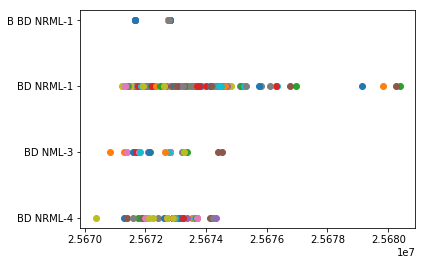

In [70]:
# visualize the optimal assignment
for i in uld_uniqueid_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.unique_id==i]['BreakDownZoneName'])
    for j in BreakDownZoneName_list1:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.unique_id==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range((min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']):
            if x[i,j,k].x > 0.5:
                #print(k)
                #print("DZ", i, "assigned to BD", j, "at", (shipment_arrival_time_minutes_loop+k))
                plt.plot(k, j, "o")
                #plt.annotate(i, (k,j))
# for j in range(m):    
#     plt.plot(1, j, "o")
# for i in range(n):
#     for j in range(m):
#         if x[i,j].x > 0.5:
#             plt.plot([0,1], [i,j], "k")# todo
plt.show

In [71]:
for i in ArrivalULDNumber_list:
    shipment_list = list(sample_shipments_bu[sample_shipments_bu.ArrivalULDNumber==i]['shipment_ID'])
    #print(shipment_list)
    for l in shipment_list:
        #print(int(i),str(j))
        number_of_ws = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Count'].unique()[0]
        shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_departure_time_minutes'].unique()[0]
        for m in range(1,number_of_ws+1):
            for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop):
                if z[l,m,t].x > 0.5:
                    print("Shipment", l, "assigned to WS", m, "at", t)

Shipment 1 assigned to WS 1 at 25674015
Shipment 7 assigned to WS 1 at 25677405
Shipment 21 assigned to WS 1 at 25673540
Shipment 30 assigned to WS 1 at 25677620
Shipment 36 assigned to WS 1 at 25673640
Shipment 37 assigned to WS 1 at 25673640
Shipment 38 assigned to WS 1 at 25673640
Shipment 48 assigned to WS 1 at 25675545
Shipment 49 assigned to WS 1 at 25675545
Shipment 50 assigned to WS 1 at 25675545
Shipment 66 assigned to WS 1 at 25674510
Shipment 74 assigned to WS 1 at 25673670
Shipment 75 assigned to WS 1 at 25673670
Shipment 82 assigned to WS 1 at 25676290
Shipment 85 assigned to WS 1 at 25677090
Shipment 89 assigned to WS 1 at 25674800
Shipment 90 assigned to WS 1 at 25674800
Shipment 91 assigned to WS 1 at 25674800
Shipment 92 assigned to WS 1 at 25674800
Shipment 93 assigned to WS 1 at 25674800
Shipment 105 assigned to WS 3 at 25677470
Shipment 106 assigned to WS 2 at 25677470
Shipment 121 assigned to WS 1 at 25673405
Shipment 2 assigned to WS 1 at 25674015
Shipment 77 assi

Shipment 281 assigned to WS 1 at 25672560
Shipment 384 assigned to WS 1 at 25673870
Shipment 135 assigned to WS 1 at 25676275
Shipment 136 assigned to WS 1 at 25676275
Shipment 137 assigned to WS 1 at 25676275
Shipment 138 assigned to WS 2 at 25676275
Shipment 139 assigned to WS 1 at 25676275
Shipment 140 assigned to WS 1 at 25676275
Shipment 141 assigned to WS 1 at 25676275
Shipment 144 assigned to WS 1 at 25675050
Shipment 145 assigned to WS 1 at 25675050
Shipment 340 assigned to WS 3 at 25681200
Shipment 341 assigned to WS 2 at 25681200
Shipment 147 assigned to WS 3 at 25673820
Shipment 236 assigned to WS 1 at 25672560
Shipment 237 assigned to WS 3 at 25672560
Shipment 238 assigned to WS 3 at 25672560
Shipment 148 assigned to WS 1 at 25673820
Shipment 175 assigned to WS 3 at 25673470
Shipment 186 assigned to WS 1 at 25673485
Shipment 150 assigned to WS 3 at 25673820
Shipment 152 assigned to WS 1 at 25673820
Shipment 153 assigned to WS 3 at 25673820
Shipment 155 assigned to WS 3 at 2

Shipment 322 assigned to WS 2 at 25674059
Shipment 323 assigned to WS 2 at 25674059
Shipment 484 assigned to WS 1 at 25674150
Shipment 485 assigned to WS 1 at 25674150
Shipment 324 assigned to WS 1 at 25674059
Shipment 487 assigned to WS 1 at 25673415
Shipment 325 assigned to WS 1 at 25681200
Shipment 326 assigned to WS 2 at 25681200
Shipment 328 assigned to WS 1 at 25672560
Shipment 414 assigned to WS 2 at 25673899
Shipment 329 assigned to WS 2 at 25674059
Shipment 449 assigned to WS 1 at 25674955
Shipment 450 assigned to WS 1 at 25674955
Shipment 332 assigned to WS 1 at 25674059
Shipment 333 assigned to WS 2 at 25674059
Shipment 335 assigned to WS 3 at 25672616
Shipment 342 assigned to WS 1 at 25681253
Shipment 343 assigned to WS 3 at 25681200
Shipment 344 assigned to WS 3 at 25681200
Shipment 345 assigned to WS 1 at 25681259
Shipment 346 assigned to WS 2 at 25674059
Shipment 348 assigned to WS 3 at 25672560
Shipment 663 assigned to WS 2 at 25674855
Shipment 349 assigned to WS 1 at 2

Shipment 616 assigned to WS 2 at 25679859
Shipment 617 assigned to WS 2 at 25679859
Shipment 620 assigned to WS 3 at 25679859
Shipment 621 assigned to WS 2 at 25679859
Shipment 622 assigned to WS 3 at 25679859
Shipment 623 assigned to WS 1 at 25679859
Shipment 624 assigned to WS 3 at 25679859
Shipment 626 assigned to WS 1 at 25672625
Shipment 627 assigned to WS 2 at 25673270
Shipment 628 assigned to WS 2 at 25673270
Shipment 629 assigned to WS 2 at 25673270
Shipment 630 assigned to WS 1 at 25673270
Shipment 633 assigned to WS 2 at 25673670
Shipment 634 assigned to WS 2 at 25673670
Shipment 635 assigned to WS 1 at 25674400
Shipment 636 assigned to WS 1 at 25674400
Shipment 638 assigned to WS 1 at 25673170
Shipment 640 assigned to WS 1 at 25676470
Shipment 642 assigned to WS 1 at 25674855
Shipment 646 assigned to WS 1 at 25680890
Shipment 651 assigned to WS 1 at 25675695
Shipment 652 assigned to WS 1 at 25675695
Shipment 653 assigned to WS 1 at 25675695
Shipment 668 assigned to WS 1 at 2

<function matplotlib.pyplot.show(*args, **kw)>

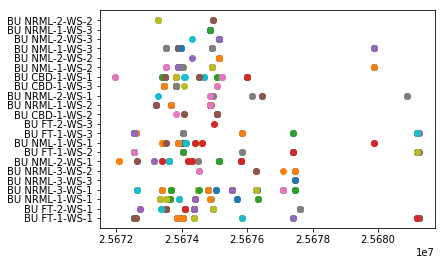

In [73]:
for i in ArrivalULDNumber_list:
    shipment_list = list(sample_shipments_bu[sample_shipments_bu.ArrivalULDNumber==i]['shipment_ID'])
    #print(shipment_list)
    for l in shipment_list:
        #print(int(i),str(j))
        number_of_ws = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Count'].unique()[0]
        shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_departure_time_minutes'].unique()[0]
        bu_zone_name = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Name_x'].unique()[0]
        flight_number = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['FlightNumber'].unique()[0]
        for m in range(1,number_of_ws+1):
            for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop):
                if z[l,m,t].x > 0.5:
                    k = str(bu_zone_name +"-WS-" + str(m))
                    #print("Shipment", l, "assigned to", bu_zone_name,"WS",m, "at", t)
                    plt.plot(t, k, "o")
                    #plt.annotate(l, (t,k))
plt.show

In [74]:
#################################################################################################################################
#################################################################################################################################
#################################################################################################################################

In [84]:
df_final_x = []
for i in uld_uniqueid_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.unique_id==i]['BreakDownZoneName'])
    #print(i, "in", BreakDownZoneName_list1)
    for j in BreakDownZoneName_list1:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.unique_id==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range((min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())) + (math.ceil((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']):
            if x[i,j,k].x > 0.5:
                df_final_x.append((i, j, k))


df_final_x1 = pd.DataFrame(df_final_x, columns=('unique_id', 'bd_name', 'assigned_time'))

In [85]:
df_final_x1.head()

,unique_id,bd_name,assigned_time
0,21231_25671250,BD NRML-4,25671312
1,21231_25671250,BD NML-3,25671280
2,24321_25671250,BD NRML-1,25671270
3,42309_25671550,BD NRML-1,25671570
4,49809_25673105,BD NRML-4,25673119


In [86]:
df_final_x1.to_csv(r'bd_assigned_time_output.csv')

In [87]:
df_final_z = []
for i in ArrivalULDNumber_list:
    shipment_list = list(sample_shipments_bu[sample_shipments_bu.ArrivalULDNumber==i]['shipment_ID'])
    #print(shipment_list)
    for l in shipment_list:
        #print(int(i),str(j))
        number_of_ws = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Count'].unique()[0]
        shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_departure_time_minutes'].unique()[0]
        bu_zone_name = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['Name_x'].unique()[0]
        flight_number = sample_shipments_bu[(sample_shipments_bu.ArrivalULDNumber==i) & (sample_shipments_bu.shipment_ID==l)]['FlightNumber'].unique()[0]
        for m in range(1,number_of_ws+1):
            for t in range(shipment_departure_time_minutes_loop-60, shipment_departure_time_minutes_loop):
                if z[l,m,t].x > 0.5:
                    #k = str(bu_zone_name +"-WS-" + str(m))
                    df_final_z.append((l,bu_zone_name ,m, t))

df_final_z = pd.DataFrame(df_final_z, columns=('shipment_id', 'bu_name', 'ws_number', 'buildup_time'))

In [88]:
df_final_z.head()

,shipment_id,bu_name,ws_number,buildup_time
0,1,BU FT-1,1,25674015
1,7,BU FT-1,1,25677405
2,21,BU FT-2,1,25673540
3,30,BU FT-2,1,25677620
4,36,BU NRML-1,1,25673640


In [89]:
df_final_x1.to_csv(r'bu_workstation_time_output.csv')

In [180]:
for i in uld_uniqueid_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.unique_id==i]['BreakDownZoneName'])
    shipment_date_list = list(sample_shipments_bu[sample_shipments_bu.unique_id==i]['departure_date'].unique())
    for d in shipment_date_list:
        shipment_list = list(sample_shipments_bu[(sample_shipments_bu.unique_id==i) & (sample_shipments_bu.departure_date==d)]['shipment_ID'])
        #print(shipment_list)
        for l in shipment_list:
            number_of_ws = sample_shipments_bu[(sample_shipments_bu.unique_id==i) & (sample_shipments_bu.shipment_ID==l)]['Count'].unique()[0]
            shipment_departure_time_minutes_loop = sample_shipments_bu[(sample_shipments_bu.unique_id==i) & (sample_shipments_bu.shipment_ID==l)]['Shipment_departure_time_minutes'].unique()[0]
            print(l)
            print(shipment_departure_time_minutes_loop)

1
25674075
6
25673700
7
25673700
3
25673600
4
25677680
8
25675605
9
25675605
10
25675605
2
25677465
5
25673700
11
25674570


In [490]:
sample_shipments_bu[sample_shipments_bu.Shipment_departure_time_minutes==25673700]

,ProductName,Priority,DropZone,ArrivalULDNumber,Pieces,Weight,TotalWeight,FlightNumberDeparture,Shipment_arrival_date_time,Shipment_departure_date_time,Shipment_duration,build_up_arrival_time,build_up_finish_time,FlightNumber,BU Zone,TransportationDistance,Name_x,HandlingTimePerULD,TransportationTimeToWH,Name_y,Count,handling_ULD_h,handling_ULD_m,handling_ULD_s,transport_WH_h,transport_WH_m,transport_WH_s,ULD_handling_h,ULD_handling_m,ULD_handling_s,arrival_date,departure_date,Shipment_duration_minutes,Shipment_arrival_time_minutes,Shipment_departure_time_minutes,shipment_ID,unique_id
35,NRML,False,DZ NRML-2,21231,1,22.6,22.6,46,2018-10-23 06:10:00,2018-10-24 23:00:00,1 days 16:50:00,2018-10-23 06:10:00,2018-10-24 23:00:00,46,BU NRML-1,00:20:00,BU NRML-1,00:20:00,00:50:00,BU NRML-1,3,0,20,0,0,50,0,0,20,0,2018-10-23,2018-10-24,2450,25671250,25673700,5,49815_25674380
36,NRML,False,DZ NRML-2,21231,3,15.5,15.5,46,2018-10-23 06:10:00,2018-10-24 23:00:00,1 days 16:50:00,2018-10-23 06:10:00,2018-10-24 23:00:00,46,BU NRML-1,00:20:00,BU NRML-1,00:20:00,00:50:00,BU NRML-1,3,0,20,0,0,50,0,0,20,0,2018-10-23,2018-10-24,2450,25671250,25673700,6,21231_25671250
37,NRML,False,DZ NRML-2,21231,1,22.3,22.3,46,2018-10-23 06:10:00,2018-10-24 23:00:00,1 days 16:50:00,2018-10-23 06:10:00,2018-10-24 23:00:00,46,BU NRML-1,00:20:00,BU NRML-1,00:20:00,00:50:00,BU NRML-1,3,0,20,0,0,50,0,0,20,0,2018-10-23,2018-10-24,2450,25671250,25673700,7,51228_25671360


In [496]:
sample_shipments_bu[(sample_shipments_bu.Shipment_arrival_time_minutes < 25674419) & (sample_shipments_bu.Shipment_arrival_time_minutes > 25674300)]

,ProductName,Priority,DropZone,ArrivalULDNumber,Pieces,Weight,TotalWeight,FlightNumberDeparture,Shipment_arrival_date_time,Shipment_departure_date_time,Shipment_duration,build_up_arrival_time,build_up_finish_time,FlightNumber,BU Zone,TransportationDistance,Name_x,HandlingTimePerULD,TransportationTimeToWH,Name_y,Count,handling_ULD_h,handling_ULD_m,handling_ULD_s,transport_WH_h,transport_WH_m,transport_WH_s,ULD_handling_h,ULD_handling_m,ULD_handling_s,arrival_date,departure_date,Shipment_duration_minutes,Shipment_arrival_time_minutes,Shipment_departure_time_minutes,shipment_ID,unique_id
448,NML,False,DZ NML-1,49815,1,1.5,1.5,11,2018-10-25 10:20:00,2018-10-25 20:55:00,10:35:00,2018-10-25 10:20:00,2018-10-25 20:55:00,11,BU FT-2,00:20:00,BU FT-2,00:24:00,00:45:00,BU FT-2,6,0,24,0,0,45,0,0,24,0,2018-10-25,2018-10-25,635,25674380,25675015,40,NaN
449,NRML,False,DZ NRML-1,49815,4,40.1,40.1,11,2018-10-25 10:20:00,2018-10-25 20:55:00,10:35:00,2018-10-25 10:20:00,2018-10-25 20:55:00,11,BU FT-2,00:20:00,BU FT-2,00:24:00,00:45:00,BU FT-2,6,0,24,0,0,45,0,0,24,0,2018-10-25,2018-10-25,635,25674380,25675015,41,NaN


In [499]:
sample_shipments_bu[sample_shipments_bu.unique_id.isna()].count()

ProductName                        32
Priority                           32
DropZone                           32
ArrivalULDNumber                   32
Pieces                             32
Weight                             32
TotalWeight                        32
FlightNumberDeparture              32
Shipment_arrival_date_time         32
Shipment_departure_date_time       32
Shipment_duration                  32
build_up_arrival_time              32
build_up_finish_time               32
FlightNumber                       32
BU Zone                            32
TransportationDistance             32
Name_x                             32
HandlingTimePerULD                 32
TransportationTimeToWH             32
Name_y                             32
Count                              32
handling_ULD_h                     32
handling_ULD_m                     32
handling_ULD_s                     32
transport_WH_h                     32
transport_WH_m                     32
transport_WH

In [565]:
for v in model.getVars():
    if(v.x > 0.5):
        print('%s %g' % (v.varName, v.x))

C15 1
C23 1
C39 1
C60 1
C72 1
C102 1
C112 1
C132 1
C161 1
C170 1
C195 1
C205 1
C230 1
C232 1
C532 1
C712 1
C892 1
C1072 1
C1252 1
C1432 1
C1612 1
C1972 1
C2272 1
C2452 1
C2632 1
C2932 1
C3172 1
C3352 1
C3532 1
C3712 1
C3892 1
C4072 1
C4252 1
C4432 1
C4612 1
C4912 1
C4972 1
C5212 1
C5572 1
C5872 1
C6112 1
C6412 1
C6712 1
C6952 1
C7192 1
C7492 1
C7792 1
C8092 1
C8452 1
C8812 1
C9112 1
C9412 1
C9592 1
C9892 1
C10192 1
C10552 1
C10912 1
C11212 1
C11632 1
C11932 1
C12232 1
C12412 1
C12592 1
C12772 1
C13072 1
C13132 1
C13312 1
C13492 1
C13672 1
C13912 1
C14272 1
C14572 1
C14872 1
C15172 1
C15412 1
C15772 1
C16132 1
C16372 1
